In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from torch.utils.data import Dataset,DataLoader

In [2]:
import os
sun_data=pd.read_csv('../input/sun-cases-all/all_sun_cases.csv')
sun_data.head()

,Case,Size
0,1,6mm
1,2,18mm
2,3,3mm
3,4,4mm
4,5,3mm


In [7]:
#Less than or equal to 
root_dir='../input/bounding-boxes-sun/Bounding Boxes/'
less_5=[]
less_10=[]
for idx in range(sun_data.shape[0]):
    item=sun_data['Size'][idx] 
    item=item[:-2]
    item=int(item)
    if item<=5:
        less_5.append(root_dir+'case'+str(sun_data['Case'][idx]))
    if 5<item<10:
        less_10.append(root_dir+'case'+str(sun_data['Case'][idx]))
print('Cases in Less 10mm : {}\nLess 18mm : {}'.format(len(less_5),len(less_10)))

Cases in Less 10mm : 60
Less 18mm : 20


In [9]:
#Images per case
less_5_images=0
less_10_images=0
             
for idx in range(len(less_5)):
        try:
                images=os.listdir(less_5[idx])
                less_5_images+=(len(images))
        except:
                continue
for idx in range(len(less_10)):
        try: 
                images=os.listdir(less_10[idx])
                less_10_images+=(len(images))
        except:
                continue
             

In [10]:
print('Less than 5mm images: {}\nLess than 10mm images: {}'.format(less_5_images,less_10_images))

Less than 5mm images: 23483
Less than 10mm images: 10462


In [11]:

#2D CNN:
import torch.nn as nn
class Net_2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(1,16,kernel_size=3,padding=1)
        self.batchnorm1=nn.BatchNorm2d(16)
        self.maxpool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(16,32,kernel_size=3,padding=1)
        self.conv3=nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.batchnorm2=nn.BatchNorm2d(64)
        self.relu=nn.ReLU(inplace=True)
        self.linear1=nn.Linear(28*28*64,128)
        self.linear2=nn.Linear(128,256)
        self.linear3=nn.Linear(256,1)
        
    def forward(self,x):
        out=self.conv1(x)
        out=self.batchnorm1(out)
        out=self.relu(out)
        out=self.maxpool(out)
        out=self.conv2(out)
        out=self.relu(out)
        out=self.maxpool(out)
        out=self.conv3(out)
        out=self.batchnorm2(out)
        out=self.relu(out)
        out=self.maxpool(out)
        out=out.view(-1,28*28*64)
        out=self.linear1(out)
        out=self.relu(out)
        #out=nn.Dropout(p=0.5)
        out=self.linear2(out)
       # out=nn.Dropout(p=0.5)
        out=self.linear3(out)
        return out


class GrayScale_ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,padding=1,stride=1)
        self.conv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1,stride=1)
        self.conv3=nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,padding=1,stride=1)
        self.conv4=nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,padding=1,stride=1)
        self.conv5=nn.Conv2d(in_channels=32,out_channels=128,kernel_size=3,padding=1,stride=1)
        self.conv6=nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1,stride=1)
        self.conv7=nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1,stride=1)
        self.maxpool=nn.MaxPool2d(kernel_size=2,stride=2)
        self.batchnorm1=nn.BatchNorm2d(num_features=32)
        self.batchnorm2=nn.BatchNorm2d(num_features=32)
        self.batchnorm3=nn.BatchNorm2d(num_features=128)
        self.batchnorm4=nn.BatchNorm2d(num_features=128)
        self.leakyrelu=nn.LeakyReLU()
        self.dropout1=nn.Dropout2d(p=0.2)
        self.dropout2=nn.Dropout(p=0.5)
        self.avgpool=nn.AdaptiveAvgPool2d((1,1))
        self.linear1=nn.Linear(128,1024)
        self.linear2=nn.Linear(1024,512)
        self.linear3=nn.Linear(512,4)
    def forward(self,x):
        # dim: b x 1 x 224 x 224
        out=self.conv1(x)
        # dim: b x 16 x 224 x 224
        out=self.conv2(out)
        # dim: b x 32 x 224 x 224
        out=self.batchnorm1(out)
        # dim: b x 32 x 224 x 224
        out=self.leakyrelu(out)
        # dim: b x 32 x 224 x 224
        out1=self.maxpool(out)
        #print(out1.shape)
        #dim : b x 32 x 112 x 112
        out=self.conv3(out1)
        #dim : b x 32 x 112 x 112
        out=self.conv4(out)
        #dim : b x 32 x 112 x 112
        #print(out.shape)
        out=out+out1
        #dim : b x 32 x 112 x 112
        #print(out.shape)
        out=self.batchnorm2(out)
        #dim : b x 32 x 112 x 112
        out=self.leakyrelu(out)
        out=self.maxpool(out)
        out=self.dropout1(out)
        out=self.conv5(out)
        #dim : b x 128 x 112 x 112
        out=self.batchnorm3(out)
        out=self.leakyrelu(out)
        out2=self.maxpool(out)
        #dim : b x 128 x 56 x 56
        out=self.conv6(out2)
        #dim : b x 128 x 56 x 56
        out=self.conv7(out)
        #dim : b x 128 x 56 x 56
        out=out+out2
        #dim : b x 128 x 56 x 56
        out=self.batchnorm4(out)
        out=self.leakyrelu(out)
        out=self.maxpool(out)
        #dim : b x 128 x 28 x 28
        out=self.avgpool(out)
        #print(out.shape)
        #dim : b x 128 x 1 x 1
        out=out.view(-1,128)
        out=self.linear1(out)
        out=self.linear2(out)
        out=self.dropout2(out)
        out=self.linear3(out)
        
        
        return out
        
        
        



In [12]:

less_5=[item.split('/')[4] for item in less_5]
less_10=[item.split('/')[4] for item in less_10]

In [13]:
from tqdm import tqdm
#Assembling images into a dataframe:
#Directory for bounding boxes:
bbx_dir='../input/bounding-boxes-sun/Bounding Boxes/'
cases_bbx=os.listdir(bbx_dir)
cases_bbx=[os.path.join(bbx_dir,item) for item in cases_bbx]
columns=['Case','Image','Label']
polyp_data=pd.DataFrame(columns=columns)
for idx,item in tqdm(enumerate(cases_bbx)):
    
    case=cases_bbx[idx]
    case=case+'/'
    case_no=case.split('/')[4]
    if case_no in less_5:
        label=0
    elif case_no in less_10:
        label=1
    else:
        continue
    images=os.listdir(case)
    images=[os.path.join(case,item) for item in images]
    for index in range(len(images)):
        temp_data=pd.DataFrame({
            'Case':[case_no],
            'Image': [images[index]],
            'Label':[label]
        })
        polyp_data=pd.concat([polyp_data,temp_data],ignore_index='True')

97it [00:49,  1.94it/s]


In [14]:
polyp_data.isnull().sum()

Case     0
Image    0
Label    0
dtype: int64

In [15]:
polyp_data.shape[0]

33945

In [16]:
import cv2
#Creating a custom dataloader:
tensor_pth='../input/sundepth224/Tensors/'
from  torch.utils.data import Dataset
class polyp_dataset(Dataset):
    def __init__(self,images_df):
        self.image_paths=images_df
    def __len__(self):
        return self.image_paths.shape[0]
    def get_labels(self):
        return self.image_paths['Label']
    def __getitem__(self,idx):
        img_path=self.image_paths['Image'][idx]
        img_name=img_path.split('/')[5]
        img_name=img_name.split('.')[0]
        img=cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
        img=cv2.resize(img,(224,224))
        img=np.array(img,dtype='float32')
        case=self.image_paths['Case'][idx]
        tensor_cas=tensor_pth+case
        tensor_img=tensor_cas+'/'+img_name+'.pt'
        #print(tensor_img)
        #print(img.shape)
        tensor_img=torch.load(tensor_img)
        tensor_img=tensor_img.numpy()
        for row in range(tensor_img.shape[0]):
            for col in range(tensor_img.shape[1]):
                if img[row][col]==255:
                    img[row][col]= tensor_img[row][col]
       # plt.subplot(1,2,1)
        #plt.imshow(tensor_img,cmap='gray')
        tensor_img=img
        #plt.subplot(1,2,2)
        #plt.imshow(tensor_img,cmap='gray')
        tensor_img=tensor_img/255.0
        tensor_img=np.expand_dims(tensor_img,axis=0)
        tensor_img=torch.Tensor(tensor_img)
        label=self.image_paths['Label'][idx]
        return tensor_img,label

In [17]:
params={
    "device":'cuda' if torch.cuda.is_available() else 'cpu',
    "batch_size":64,
    "epochs":2,
    "lr":0.0001
}

In [18]:
#Creating train test and valid datasets
from sklearn.model_selection import train_test_split
Polyp_Train,Polyp_Valid=train_test_split(polyp_data,random_state=42,shuffle=True,test_size=0.2)
Polyp_Valid,Polyp_Test=train_test_split(Polyp_Valid,random_state=42,shuffle=True,test_size=0.5)

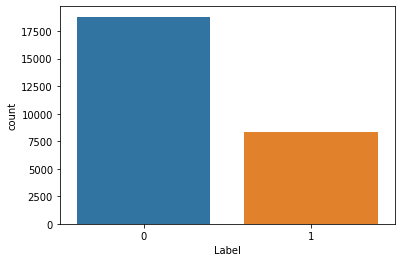

In [19]:
import seaborn as sns
sns.countplot(data=Polyp_Train,x=Polyp_Train['Label'])
plt.show()

In [20]:
print('Length of Training Data: {}\nLength of Testing Data: {}\nLength of Validation Data: {}'.format(Polyp_Train.shape[0],Polyp_Test.shape[0],Polyp_Valid.shape[0]))

Length of Training Data: 27156
Length of Testing Data: 3395
Length of Validation Data: 3394


In [21]:
#Reseting indices
Polyp_Train=Polyp_Train.reset_index()
Polyp_Train=Polyp_Train.drop(columns='index',axis=1)
#Polyp_Train=Polyp_Train.drop(columns='level_0',axis=1)
Polyp_Train.head()

,Case,Image,Label
0,case14,../input/bounding-boxes-sun/Bounding Boxes/cas...,0
1,case86,../input/bounding-boxes-sun/Bounding Boxes/cas...,0
2,case38,../input/bounding-boxes-sun/Bounding Boxes/cas...,0
3,case93,../input/bounding-boxes-sun/Bounding Boxes/cas...,1
4,case3,../input/bounding-boxes-sun/Bounding Boxes/cas...,0


In [22]:
Polyp_Test=Polyp_Test.reset_index()
Polyp_Test=Polyp_Test.drop(columns='index',axis=1)
#Polyp_Test=Polyp_Test.drop(columns='level_0',axis=1)
Polyp_Test.head()

,Case,Image,Label
0,case3,../input/bounding-boxes-sun/Bounding Boxes/cas...,0
1,case59,../input/bounding-boxes-sun/Bounding Boxes/cas...,1
2,case59,../input/bounding-boxes-sun/Bounding Boxes/cas...,1
3,case98,../input/bounding-boxes-sun/Bounding Boxes/cas...,0
4,case85,../input/bounding-boxes-sun/Bounding Boxes/cas...,1


In [34]:
Polyp_Valid=Polyp_Valid.reset_index()
Polyp_Valid=Polyp_Valid.drop(columns='index',axis=1)
#Polyp_Test=Polyp_Test.drop(columns='level_0',axis=1)
Polyp_Valid.head()

,Case,Image,Label
0,case89,../input/bounding-boxes-sun/Bounding Boxes/cas...,0
1,case59,../input/bounding-boxes-sun/Bounding Boxes/cas...,1
2,case46,../input/bounding-boxes-sun/Bounding Boxes/cas...,0
3,case93,../input/bounding-boxes-sun/Bounding Boxes/cas...,1
4,case16,../input/bounding-boxes-sun/Bounding Boxes/cas...,0


In [25]:
from torchsampler import ImbalancedDatasetSampler


In [35]:
#Creating datasets
train_dataset=polyp_dataset(Polyp_Train)
test_dataset=polyp_dataset(Polyp_Test)
validation_dataset=polyp_dataset(Polyp_Valid)

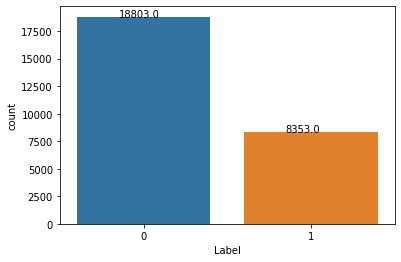

In [36]:
import seaborn as sns
ax=sns.countplot(data=Polyp_Train,x=Polyp_Train['Label'])
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

plt.show()

In [ ]:
#weights=[1./18808,1./10491,1.0/3101.0,1./6199.0]
#samples_weight = np.array([weights[t] for t in Polyp_Train['Label']])
#samples_weight = torch.from_numpy(samples_weight)
#from torch.utils.data import WeightedRandomSampler
#sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

In [38]:

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    sampler=ImbalancedDatasetSampler(train_dataset),
    batch_size=64,
    
)

In [39]:
#Creating dataloaders
from torch.utils.data import DataLoader
#train_loader=DataLoader(dataset=train_dataset,num_workers=2,pin_memory=True,batch_size=params['batch_size'])
test_loader=DataLoader(dataset=test_dataset,num_workers=2,pin_memory=True,shuffle=False,batch_size=params['batch_size'])
val_loader=DataLoader(dataset=validation_dataset,num_workers=2,pin_memory=True,shuffle=False,batch_size=params['batch_size'])

In [42]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        images=images.float()
        target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
        output = model(images)
        loss = criterion(output, target)
        accuracy = calculate_accuracy(output, target)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [43]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            images=images.float()
            target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
            output = model(images)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(output, target)

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

In [44]:
def calculate_accuracy(output, target):
    output = torch.sigmoid(output) >= 0.5
    target = target == 1.0
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [45]:
model=Net_2D()
model=model.cuda()
criterion = nn.BCEWithLogitsLoss().to(params["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])

In [46]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
cudnn.benchmark = True

In [47]:
for epoch in range(1, params["epochs"] + 1):
    train(train_loader, model, criterion, optimizer, epoch, params)
    validate(val_loader, model, criterion, epoch, params)

Epoch: 1. Train.      Loss: 0.530 | Accuracy: 0.733: 100%|██████████| 425/425 [1:19:29<00:00, 11.22s/it]
Epoch: 1. Validation. Loss: 0.487 | Accuracy: 0.772: 100%|██████████| 54/54 [08:09<00:00,  9.07s/it]
Epoch: 2. Train.      Loss: 0.373 | Accuracy: 0.835: 100%|██████████| 425/425 [1:16:41<00:00, 10.83s/it]
Epoch: 2. Validation. Loss: 0.405 | Accuracy: 0.823: 100%|██████████| 54/54 [07:54<00:00,  8.79s/it]


In [48]:
torch.save(model,'./two_classes_5_10.pt')
torch.save(model.state_dict(),'./two_classes_5_10_st_dict.pt')

In [ ]:
import torch
model=torch.load('../input/model1/four_classes_model2.pt')

In [49]:
preds=[]
targets=[]
from tqdm import tqdm
with torch.no_grad():
    model.eval()
    for idx,data in tqdm(enumerate(test_loader)):
        img,label=data
        img=img.cuda()
        label=label.cuda()
        pred=model(img)
        
        preds.append(pred)
        targets.append(label)

54it [08:08,  9.05s/it]


In [50]:
new_preds=[]

for item in range(len(preds)):
    for idx in range(len(preds[item])):
        ele=preds[item][idx].cpu()
        ele=torch.sigmoid(ele)
        if ele>=0.5:
            ele=1
        else:
            ele=0
        new_preds.append(ele)

In [51]:
new_targets=[]


for item in range(len(targets)):
    for idx in range(len(targets[item])):
        ele=targets[item][idx].cpu()
        new_targets.append(ele)

In [52]:
new_targets=np.array(new_targets)
new_preds=np.array(new_preds)
for idx in range(new_targets.shape[0]):
    new_targets[idx]=int(new_targets[idx])
    new_preds[idx]=int(new_preds[idx])

In [53]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm=confusion_matrix(new_targets,new_preds)

In [54]:
cm

array([[1988,  344],
       [ 253,  810]])

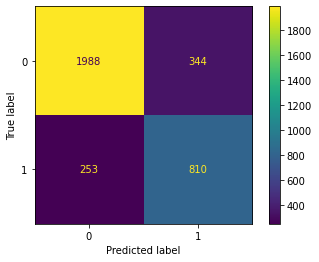

In [55]:
disp=ConfusionMatrixDisplay(cm)

disp.plot()
plt.show()

In [56]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [57]:
accuracy=accuracy_score(new_preds,new_targets)
accuracy

0.8241531664212076

In [58]:
recall_score=recall_score(new_preds,new_targets)
recall_score

0.7019064124783362

In [59]:
precision=precision_score(new_preds,new_targets)
precision

0.761994355597366

In [60]:
f1=f1_score(new_preds,new_targets)
f1

0.7307171853856562